# Customer Segmentation of Arvato-Bertelsmann customers

The Arvato-Group is one of total 8 business units in the Bertelsmann Group which is a worldwide operating service company head-quarted in Germany.<br>
The main operating field of Avarto are logistics- and supply chain services and solutions, financial services as well as the operation of IT Systems. Concerning the general figures to get a grasp of the company, the company employs a staff around 77.342 persons (2020) and generates a sales volume of 5.56 Mrd. EUR per a (2024).

The present project can be localized in the financial services branch of Arvato (Arvato Financial Solutions).<br><br>
<span style="color: green;">**One client of Arvato Financial Solutions, a Mail-Order Company selling organic products, wants to be advised concerning a more efficient way to acquire new clients.<br>
In essence, the company wants their acquisition marketing campaings instead of reaching out to everyone (costly), target more precisely those persons which show the highest probability to turn into new customers.**</span>
<br><br>
<span style="text-decoration: underline;">The project spans two main tasks:</span>
1) Customer Segmentation: An Analysis of the existing customer database dataset is carried out and on this basis a general recommandation of which people in Germany are most likely to be new customers of the company is generated. <br><br>
2) Modelling Campaign-Responses: Using the results of 1) to build a machine learning model that predicts whether or not an individual will respond to the respective campaign.

This notebook focuses on the second main task.




## II. Methodology

The present part of the project is going to have the following structure: 

Part 1:
* In the first part, train set is loaded, separated in X / y set and a preprocessing / ML Pipeline is established to standardize the processing steps in order to perform them for multiple models in the following procedure. <br>
The Pipeline consists (partly inspired by the customer segmentation part) of the following parts:
    * Replace unknown values with np.nan
    * Drop specific columns which are (subjectively) not important for the prediction
    * Handling missing values (columns with a missing value rate of > 50 % are dropped)
    * Handling high correlation between the features (if there is a bi-directional correlation of > 85 % observed, the feature with the most nan values of the two is dropped)
    * Process youth years, where the movement and the youth-years of the individuals are extracted from the feature "PRÄGENDE_JUGENDJAHRE"  
    * Imputing missing values, where the resting features are processed concerning missing values. A most-frequent imputer is used
    * Encode the categorical features
    * A StandardScaler is used to scale the X features to address dominance in the effect of a feature on the prediction due to its scale
    * After that due to the high inbalance between the y=0 and the y=1 values in the target, an Random Undersampling step is performed to undersample the majority class and provide the best basis possible for the models to learn to difference between the target values
    * The pipelines closes with a machine learning model which fits the preprocessed X on y  <br>

* This pipeline is used in combination with 5-fold crossvalidation and multiple models to evaluate along AUC Score, Precision and Recall their performance
* and finally choose the best performing model on the task in order to find the optimal hyperparameter in the second part
---
Part 2:
* Based on the first part, the Pipeline of part 1 is re-used and the best performing model in part 1 is fine-tuned with Grid Search
-> the hyperparameter range is chosen and the Grid Search algorithm is leverage in combination with 5 fold crossvalidation to find the best hyperparameters
* The resulting hyperparameters and the resulting averaged crossvalidation score is the final model performance to provide to the company in order to predict which individuals to aim in their marketing campaigns
---
Notes: 
* The Test-set is not used in the present notebook because the respective Kaggle Competition isn't open anymore for verifying the test results and the y_test (RESPONSE) variable is not provided.

<img src = '../data/img/procedure_supervised_learning.PNG'/>

## II. Loading the data and importing the libraries

In [169]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', None)

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [139]:
root_path = os.path.dirname(os.getcwd())

mailout_train = pd.read_csv(rf'{root_path}\data\modeling\Udacity_MAILOUT_052018_TRAIN.csv', sep=';', low_memory=False)
#mailout_test = pd.read_csv(rf'{root_path}\data\modeling\Udacity_MAILOUT_052018_TEST.csv', sep=';', low_memory=False)

feature_summary = pd.read_excel(rf'{root_path}\data\description\DIAS Attributes - Values 2017.xlsx')

In [140]:
#original data not to be touched
mailout_train_original = mailout_train.copy()
#mailout_test_original = mailout_test.copy()

Checking the data

In [141]:
mailout_train.info(verbose = True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Data columns (total 367 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    LNR                          42962 non-null  int64  
 1    AGER_TYP                     42962 non-null  int64  
 2    AKT_DAT_KL                   35993 non-null  float64
 3    ALTER_HH                     35993 non-null  float64
 4    ALTER_KIND1                  1988 non-null   float64
 5    ALTER_KIND2                  756 non-null    float64
 6    ALTER_KIND3                  174 non-null    float64
 7    ALTER_KIND4                  41 non-null     float64
 8    ALTERSKATEGORIE_FEIN         34807 non-null  float64
 9    ANZ_HAUSHALTE_AKTIV          35185 non-null  float64
 10   ANZ_HH_TITEL                 34716 non-null  float64
 11   ANZ_KINDER                   35993 non-null  float64
 12   ANZ_PERSONEN                 35993 non-null  float64
 13  

In [142]:
#mailout_test.info(verbose = True, memory_usage=True, show_counts=True)
#np.setdiff1d(mailout_train.columns, mailout_test.columns)

Same column count as in the dataset of the segmentation section.

In [143]:
mailout_train["RESPONSE"].value_counts()

RESPONSE
0    42430
1      532
Name: count, dtype: int64

Strongly unbalanced training set which needs to be adressed in the further procedure.

## III. Data Preparation & Training

In [144]:
#drop rows with too many missing values
mailout_train_dropped = mailout_train[mailout_train.isnull().sum(axis = 1)<100].copy()

#split the data in train and test set
X_train, y_train = mailout_train_dropped.drop("RESPONSE", axis = 1), mailout_train_dropped["RESPONSE"].copy()

#X_test = mailout_test.copy()

In [110]:
class Replace_unknown_values(BaseEstimator, TransformerMixin):
    def __init__(self):      

        self.feature_summary = pd.read_excel(rf'{root_path}\data\description\DIAS Attributes - Values 2017.xlsx')
        self.mapping = {}
        self.ls = []

    def fit(self, X, y = None):
        self.feat_unknown = self.feature_summary[self.feature_summary["Meaning"] == "unknown"]
        for col in self.feat_unknown["Attribute"].unique():
            self.ls = self.feat_unknown[self.feat_unknown["Attribute"] == col]["Value"].values.tolist()

        if isinstance(self.ls[0], str):
            self.mapping[col] = [int(element) for element in self.ls[0].split(",")]
        else:
            self.mapping[col] = self.ls

        return self
    
    def transform(self, X, y = None):

        for col in X.columns:
            if col in list(self.mapping.keys()):
                X[col] = np.where(X[col].isin(self.mapping[col]), np.nan, X[col])  

        X = X.replace(["XX", "X"], np.nan)

        return X
    
class Drop_specific_cols(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        
        print(X.shape)

        X = X.drop(self.columns, axis = 1)
        print(f"The following columns have been dropped: {self.columns}")

        return X

class Handle_missing_columns(BaseEstimator, TransformerMixin):
    def __init__(self, missing_value_params):
        self.missing_value_params = missing_value_params

        self.col_threshold = self.missing_value_params["col_threshold"]
        self.rows_to_drop = None
        self.cols_to_drop = None

    def fit(self, X, y = None):
    
        self.cols_to_drop = X.isnull().mean()[X.isnull().mean()>self.col_threshold].index
        return self

    def transform(self, X, y = None):

        X = X.drop(self.cols_to_drop, axis = 1)
        return X
    
class Handle_high_correlation(BaseEstimator, TransformerMixin):
    def __init__(self, corr_threshold, untouchable_feats):
        self.corr_threshold = corr_threshold
        self.untouchable_feats = untouchable_feats
        self.to_drop = []

    def fit(self, X, y = None):
        
        def create_correlation_report(df, corr_threshold = 0.85):
            """Create a correlation report respective opposing features with their bivariate correlation exceeding the given correlation threshold

            Args:
                df (pandas.DataFrame): input dataframe
                corr_threshold (float, optional): Correlation threshold to verify. Defaults to 0.85.

            Returns:
                pandas.DataFrame: Correlation Report
            """
            #get only numerical features for correlation analysis
            num_colums = df.select_dtypes(include = ["float64", "int64"])

            #calculate the correlation matrix for these features
            correlation_mat = num_colums.corr()

            #find the indices of elements in the matrix which satisfy the given condition > threshold
            high_corr_pairs = np.where(np.abs(correlation_mat) > corr_threshold)

            #data store for further processing
            high_corr_list = []

            for i in range(len(high_corr_pairs[0])):
                if high_corr_pairs[0][i] != high_corr_pairs[1][i]: #exclude cases where a feature is compared to itself
                    column_1 = correlation_mat.columns[high_corr_pairs[0][i]] #save the column 1 of a high corr pair
                    column_2 = correlation_mat.columns[high_corr_pairs[1][i]] #save the column 2 of a high corr pair
                    
                    #get the relevant correlation of the high correlation pair
                    high_corr_list.append((
                        column_1, 
                        column_2, 
                        correlation_mat.iloc[high_corr_pairs[0][i], high_corr_pairs[1][i]]
                        )) 

            #convert the result in a dataframe incl. sorting by corr value desc
            high_corr_report = pd.DataFrame(high_corr_list, columns=["feat_1", "feat_2", "corr"]).sort_values("corr", ascending = False)

            high_corr_report["key"] = high_corr_report.apply(lambda x: sorted([x["feat_1"], x["feat_2"]]), axis = 1)
            high_corr_report.drop_duplicates(subset="key", inplace=True)
            high_corr_report.drop("key", axis = 1, inplace = True)

            return high_corr_report

        def determine_features_to_drop(df, corr_report, features_to_keep = []):
            """Determine the highly correlated features to drop based on the correlation report. 
            if a pair is highly correlated the column is dropped with the higher missing value rate

            Args:
                df (pandas.DataFrame): input df for the determination 
                corr_report (_type_): _description_

            Returns:
                list: list with features to drop
            """
            df_ = df.copy()

            feat_1_nan = df_[corr_report["feat_1"].unique().tolist()].isnull().mean().to_frame().reset_index().rename({"index": "feat_1", 0:"missing_rate_feat_1"}, axis = 1)
            feat_2_nan = df_[corr_report["feat_2"].unique().tolist()].isnull().mean().to_frame().reset_index().rename({"index": "feat_2", 0:"missing_rate_feat_2"}, axis = 1)

            corr_report = pd.merge(
                left = corr_report,
                right = feat_1_nan,
                on = "feat_1",
                how = "left"
            )

            corr_report = pd.merge(
                left = corr_report,
                right = feat_2_nan,
                on = "feat_2",
                how = "left"
            )

            corr_report["feature_to_drop"] = corr_report.apply(lambda x: x["feat_1"] if x["missing_rate_feat_1"] > x["missing_rate_feat_2"] else x["feat_2"], axis = 1)
            to_drop_ls = corr_report["feature_to_drop"].copy().tolist()

            to_drop_ls = [feat for feat in to_drop_ls if feat not in features_to_keep]
            
            return to_drop_ls

        corr_report = create_correlation_report(X, self.corr_threshold)
        self.to_drop = determine_features_to_drop(X, corr_report, self.untouchable_feats)

        return self

    def transform(self, X, y = None):

        X = X.drop(self.to_drop, axis = 1)
                    
        return X

class Process_youth_years(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_summary = pd.read_excel(rf'{root_path}\data\description\DIAS Attributes - Values 2017.xlsx')

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        
        def extract_movement(txt):
            """Extract the movement from the Attribute PRAEGENDE_JUGENDJAHRE	

            Args:
                txt (str): text value of the attribute PRAEGENDE_JUGENDJAHRE	

            Returns:
                str: if extraction works out: movement type, else: input value
            """

            try:

                start_ = re.search(r"\(", txt).start()
                end_ = re.search(r"\)", txt).start() + 1

                return_txt = txt[start_: end_]
                txt_ls = return_txt.split(",")

                return txt_ls[0][1:]
            except:
                
                return txt

        def get_mapping(feature):
            """Function to provide a feature mapping from feature values to meaning of these values

            Args:
                feature (str): Feature to provide a mapping for

            Raises:
                LookupError: if a feature is not found in the feature_summary dataframe. This error is raised to inform the user of the non-existence

            Returns:
                dict: Dictionary with the mapping feature_value:meaning 
            """

            if feature in self.feature_summary["Attribute"].unique().tolist():
                mapping_ = self.feature_summary[self.feature_summary["Attribute"] == feature][["Value", "Meaning"]].set_index("Value").to_dict()["Meaning"]
            else:
                raise LookupError("Can't find the provided feature in data.")

            return mapping_
        
        X_ = X["PRAEGENDE_JUGENDJAHRE"].copy().to_frame()
        X_["praegende_jugendjahre_cat"] = X_["PRAEGENDE_JUGENDJAHRE"].map(get_mapping("PRAEGENDE_JUGENDJAHRE"))

        X_["youth_years"] = X_["praegende_jugendjahre_cat"].apply(lambda x: str(x)[:2])
        X_["movement_type"] = X_["praegende_jugendjahre_cat"].str[:].apply(lambda x: extract_movement(x))

        X.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)
        X = pd.concat([X, X_], axis = 1)

        X.drop("praegende_jugendjahre_cat", axis = 1, inplace = True)
        X.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)

        return X

class Impute_missing_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = None
        self.df_dtypes = None

    def fit(self, X, y = None):
        self.imputer = SimpleImputer(strategy="most_frequent")
        self.df_dtypes = {feat: str(X.dtypes.loc[feat]) for feat in X.dtypes.index}
        self.imputer.fit(X)

        return self

    def transform(self, X, y = None):   
        
        X = pd.DataFrame(self.imputer.transform(X), columns = X.columns)
        for col in list(self.df_dtypes.keys()):
            X[col] = X[col].astype(self.df_dtypes[col])

        return X

class Encode_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feats_to_encode = None
        self.encoder = None
        self.o_w_mapping = None

    def fit(self, X, y = None):
        
        self.feats_to_encode = X.select_dtypes(include = ["object"]).columns.tolist()
        X_cat = X[self.feats_to_encode].copy()
        

        #encode cat
        self.encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=True, drop = "if_binary")
        self.encoder.fit(X_cat)

        return self

    def transform(self, X, y = None):   
        
        X_cat = X[self.feats_to_encode].copy()
        X_num = X.drop(self.feats_to_encode, axis = 1)

        X_cat_encoded = self.encoder.transform(X_cat).todense()

        categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in self.encoder.categories_[i]]

        print("X_cat_encoded shape: ",X_cat_encoded.shape)
        print("cat cols list: ", categorical_columns)

        X_cat_encoded = pd.DataFrame(X_cat_encoded, columns = self.encoder.get_feature_names_out().tolist())    

        X = pd.concat([X_num, X_cat_encoded], axis = 1).reset_index()

        return X
    
class Scaling_features(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = None

    def fit(self, X, y = None):
        
        self.scaler = StandardScaler()
        self.scaler.fit(X)        

        return self

    def transform(self, X, y = None):   

        X = pd.DataFrame(self.scaler.transform(X), columns = X.columns)
        
        print("check scaling")

        return X
#####################################

In the above part of the section the individual custom transformer for the different preprocessing steps are defined. <br>
These transformers are then used below to define the different steps of the pipeline. Each custom transformer has to inherit from the BaseEstimator & the TransformerMixin class and implement an __init__, a fit and a fit_transform method.

In the different steps of the pipeline several arguments can be defined which are passed to the different customers.<br>

In [145]:
missing_value_params = {
        "col_threshold": 0.5
}
non_informative_feats = ["LNR", "EINGEFUEGT_AM", "EINGEZOGENAM_HH_JAHR", "NATIONALITAET_KZ", "D19_LETZTER_KAUF_BRANCHE", "CAMEO_DEU_2015", "CAMEO_INTL_2015"]

ml_pipeline = Pipeline(steps = [
    ('replace_unknown_values', Replace_unknown_values()),
    ('drop_specific_columns', Drop_specific_cols(columns = non_informative_feats)),
    ('handle_missing_values', Handle_missing_columns(missing_value_params=missing_value_params)),
    ('handle_high_correlation', Handle_high_correlation(corr_threshold=0.85, untouchable_feats=["PRAEGENDE_JUGENDJAHRE"])),
    ('process_youth_years', Process_youth_years()),
    ('impute_missing_data', Impute_missing_data()),
    ('encode_features', Encode_features()),
    ('scale_features', Scaling_features()),
    ("undersampling", RandomUnderSampler(sampling_strategy="majority", random_state=42)),
    ("model", LogisticRegression(class_weight = "balanced"))
])

To evaluate the different models, we use the ROC-AUC Score (Receiver Operating Characteristic - Area Under the Curve), Recall and Precision.

As the dataset shows a certain degree of class imbalance, it is possible that the model learns dominantly one of the classes, but doesn't adapt for the other class. 

The ROC-AUC Score is a metric taking both classes into account as it represents a tradeoff between the TPR (True Positive Rate or Recall) and the FPR (False Positive Rate).
Moreover it is less sensitive to class distribution compared to metrics such as accuracy which makes it more reliable for imbalanced datasets.
<br>
Beside the ROC-AUC Score also the Recall and the Precision is taken into account to have a more complete view on the performance of the model.

In [146]:
#define k-fold stratified Crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [174]:
scoring = {
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, average='macro')
}

models = {
    "Naive Classifier": DummyClassifier(strategy="stratified"),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "AdaBoostClassifier": AdaBoostClassifier(n_estimators=200, random_state=42),
    "XGboost": XGBClassifier(n_estimators = 200, random_state=42)
}

cv_scores = {

}


for model in list(models.keys()):

    ml_pipeline.set_params(model = models[model])

    print(f"Crossvalidating model {model}...")

    current_scoring = cross_validate(
        estimator=ml_pipeline,
        X = X_train,
        y = y_train,
        cv=skf,
        n_jobs=-1,
        verbose=0,
        scoring=scoring
    )

    cv_scores[model] = current_scoring

    for k in list(cv_scores[model].keys()):
        current_values = cv_scores[model][k]
        print(f"{k}: {current_values}")


    print("-"*50)

Crossvalidating model Naive Classifier...
fit_time: [11.51643586 11.4812181  11.19992805 11.52268267 11.48821783]
score_time: [0.57694507 0.57609034 0.62873173 0.59272194 0.56709099]
test_precision: [0.50237449 0.50105328 0.49938865 0.50104973 0.49945251]
test_recall: [0.54834719 0.521453   0.48754886 0.52138067 0.48885076]
test_f1: [0.35128133 0.34639533 0.34508012 0.3463277  0.34628555]
test_roc_auc: [0.54834719 0.521453   0.48754886 0.52138067 0.48885076]
--------------------------------------------------
Crossvalidating model RandomForestClassifier...
fit_time: [14.04439759 14.5463531  14.58077502 14.52182078 14.5050571 ]
score_time: [0.66873455 0.86760974 0.93967485 0.84923124 0.81170845]
test_precision: [0.51265812 0.51012728 0.51161904 0.51320095 0.51020472]
test_recall: [0.73290785 0.6823077  0.71003074 0.74801266 0.69112001]
test_f1: [0.42545491 0.42709609 0.42842184 0.42014673 0.41657132]
test_roc_auc: [0.73290785 0.6823077  0.71003074 0.74801266 0.69112001]
-----------------

In [175]:
for model in list(cv_scores.keys()):

    models_mean = np.mean(cv_scores[model]['test_roc_auc'])
    print(f"Model {model}: {np.round(models_mean,2)}")

Model Naive Classifier: 0.51
Model RandomForestClassifier: 0.71
Model LogisticRegression: 0.6
Model AdaBoostClassifier: 0.68
Model XGboost: 0.72


In [176]:
cv_score_avg = {}

for key in list(cv_scores.keys()):

    tmp_dict = {}
    for attribute in list(cv_scores[key].keys()):
        tmp_dict[attribute] = np.round(np.mean(cv_scores[key][attribute]), 2).item()
    
    cv_score_avg[key] = tmp_dict

In [177]:
pd.DataFrame().from_dict(cv_score_avg)

,Naive Classifier,RandomForestClassifier,LogisticRegression,AdaBoostClassifier,XGboost
fit_time,11.44,14.44,14.25,14.52,14.40
score_time,0.59,0.83,0.64,2.51,0.68
test_precision,0.50,0.51,0.50,0.51,0.51
test_recall,0.51,0.71,0.60,0.68,0.72
test_f1,0.35,0.42,0.38,0.41,0.43
test_roc_auc,0.51,0.71,0.60,0.68,0.72


**Evaluation of the models:**
* The Naive Classifier scores a ROC-AUC Score of around 0.5 which means that it's ability to distinguish between the two classes is not given.
* The logistic regression classifier outperforms slightly the Naive Classifier (~0.6), but is outperformed by the Treemodels
* RandomForest performs in relation very well (~0.71)
* The Boosting ensemble XGBoost Model performs with a roc-auc score of ~0.72 also very well
* The Adaboost classifier lies with roc-auc=~0.68 between the XGBoost / RandomForest and the Logistic Regression
<br>

For the next step, the hyperparameter tuning will be performed with XGBoost and RandomForest, because of their result in the first crossvalidation step.

## IV. Hyperparameter Tuning

Hyperparameter Tuning is an essential step in this Data Science project as the model can be fine-tuned to the problem at hand. 
For this task the GridSearch Procedure is used. In this simple algorithm, the Data Scientist / Researcher configures a parameter grid containing a desired number of model hyperparameter followed by a list of hyperparameter values for these respective hyperparameters which have to be tested.

The algorithm performs for each of the hyperparameter value combinations a crossvalidation and determines the best performing hyperparameter combination.<br>
The XGBoost Classifier and the RandomForestClassifier which has been chosen in the previous step, are tree models prone to overfitting and therefore the possible hyperparameter (values) set up for GridSearch have been chosen considering this challenge. 
In addition to that, the time performing the GridSearch has been also a factor as with every new hyperparameter value to test the time for determining the best model scales up.

In [178]:
#split train data in train / test
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

## Model 1: XGBoost

Especially Boosting algorithm are prone to overfitting. Therefore max_depth and the learning_rate as well as the sampling parameters have been chosen to optimize while preventing overfitting the best possible way.

In [186]:
ml_pipeline.set_params(model = models["XGboost"])

hyperparams_xgb = {
    'model__objective': ["binary:logistic"],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [5, 7],
    'model__subsample': [0.6, 0.8],
    'model__colsample_bytree': [0.8, 1.0],
    'model__n_estimators': [200, 300],
    'model__tree_method': ['gpu_hist']
}

grid_search_xgb = GridSearchCV(estimator=ml_pipeline, param_grid=hyperparams_xgb, scoring = scoring, cv = skf, verbose = 1, return_train_score= True, refit = "roc_auc", n_jobs=-1)
grid_search_xgb.fit(X_train_, y_train_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
(28000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (28000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'youth_years_40', 'youth_years_50', 'youth_years_60', 'youth_years_70', 'youth_years_80', 'youth_years_90', 'youth_years_na', 'movement_type_Avantgarde', 'movement_type_Mainstream']
check scaling


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('replace_unknown_values',
                                        Replace_unknown_values()),
                                       ('drop_specific_columns',
                                        Drop_specific_cols(columns=['LNR',
                                                                    'EINGEFUEGT_AM',
                                                                    'EINGEZOGENAM_HH_JAHR',
                                                                    'NATIONALITAET_KZ',
                                                                    'D19_LETZTER_KAUF_BRANCHE',
                                                                    'CAMEO_DEU_2015',
                                                                    'CAMEO_INTL_2015'])),
                                       ('handle_missing_...
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict', average=macro)},
             verbose=1)

In [187]:
opt_xgboost_params = grid_search_xgb.best_params_
opt_xgboost_params

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.01,
 'model__max_depth': 5,
 'model__n_estimators': 200,
 'model__objective': 'binary:logistic',
 'model__subsample': 0.6,
 'model__tree_method': 'gpu_hist'}

## Model 2: RandomForestClassifier

The RandomForestclassifier is also a decision tree classifier, but in opposite to XGBoost the algorithm isn't a boosting algorithm, which build the decision tree sequentially where each sequential tree "corrects" the model's error. 
This algorithm is based on the bagging method (bootstrap aggregating) where multiple models are in parallel fit on respective random samples (rows and features) of the data and then are aggregated to a final prediction.

This makes RandomForest more robust and therefore the classifier is already in its inherent architecture preventing overfitting. Therefore the parameters are chosen in a way so that the Gridsearch algorithm has a high probability to find well fitting parameters.

In [188]:
ml_pipeline.set_params(model = models["RandomForestClassifier"])

hyperparams_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_leaf': [2, 4]
}

grid_search_rf = GridSearchCV(estimator=ml_pipeline, param_grid=hyperparams_rf, scoring = scoring, cv = skf, verbose = 1, return_train_score= True, refit = "roc_auc", n_jobs=-1)
grid_search_rf.fit(X_train_, y_train_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
(28000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (28000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'youth_years_40', 'youth_years_50', 'youth_years_60', 'youth_years_70', 'youth_years_80', 'youth_years_90', 'youth_years_na', 'movement_type_Avantgarde', 'movement_type_Mainstream']
check scaling


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('replace_unknown_values',
                                        Replace_unknown_values()),
                                       ('drop_specific_columns',
                                        Drop_specific_cols(columns=['LNR',
                                                                    'EINGEFUEGT_AM',
                                                                    'EINGEZOGENAM_HH_JAHR',
                                                                    'NATIONALITAET_KZ',
                                                                    'D19_LETZTER_KAUF_BRANCHE',
                                                                    'CAMEO_DEU_2015',
                                                                    'CAMEO_INTL_2015'])),
                                       ('handle_missing_...
             refit='roc_auc', return_train_score=True,
             scoring={'f1': make_scorer(f1_score, response_method='predict', average=macro),
                      'precision': make_scorer(precision_score, response_method='predict', average=macro),
                      'recall': make_scorer(recall_score, response_method='predict', average=macro),
                      'roc_auc': make_scorer(roc_auc_score, response_method='predict', average=macro)},
             verbose=1)

In [189]:
opt_rf_params = grid_search_rf.best_params_
opt_rf_params

{'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__n_estimators': 100}

## V. Evaluation and Discussion

After having now determined the most optimal hyperparameter on the train data (X_train_, y_train_) for the two models, these hyperparameter are used to fit a model on the X_train_ and y_train_ set.<br>
Hereafter, the trained models are tested on the X_test_ set which represents the unseen data to evaluate it afterwards on the y_test_ data.

## Model 1: XGB

In [192]:
ml_pipeline.set_params(model = models["XGboost"])

ml_pipeline.set_params(**opt_xgboost_params)

ml_pipeline.fit(X_train_, y_train_)
yhat_xgb = ml_pipeline.predict_proba(X_test_)
y_pred_xgb = ml_pipeline.predict(X_test_)
pos_probs_xgb = yhat_xgb[:, 1]

#metrics
roc_auc_test_xgb = roc_auc_score(y_true = y_test_, y_score = yhat_xgb[:, 1])
recall_test_xgb = recall_score(y_true = y_test_, y_pred=y_pred_xgb)
precision_test_xgb = precision_score(y_true = y_test_, y_pred=y_pred_xgb)

(28000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (28000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'youth_years_40', 'youth_years_50', 'youth_years_60', 'youth_years_70', 'youth_years_80', 'youth_years_90', 'youth_years_na', 'movement_type_Avantgarde', 'movement_type_Mainstream']
check scaling
(7000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (7000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 

In [193]:
print(f"The final roc_auc_score on the unseen testset is: {np.round(roc_auc_test_xgb,2)}\n")
print(classification_report(y_true = y_test_, y_pred= y_pred_xgb))

The final roc_auc_score on the unseen testset is: 0.79

              precision    recall  f1-score   support

           0       1.00      0.69      0.81      6913
           1       0.03      0.84      0.06        87

    accuracy                           0.69      7000
   macro avg       0.51      0.76      0.44      7000
weighted avg       0.99      0.69      0.80      7000



The XGBoost model with the determined hyperparameters reached a 
* Roc-Auc Score of 0.79 
* a weighted avg of recall is about 0.69 (0.69 on the non-respondends and 0.84 on the respondends)
* the precision value on the responded class is very low 
------------

## Model 2: RandomForest

In [197]:
ml_pipeline.set_params(model = models["RandomForestClassifier"])

ml_pipeline.set_params(**opt_rf_params)

ml_pipeline.fit(X_train_, y_train_)
yhat_rf = ml_pipeline.predict_proba(X_test_)
y_pred_rf = ml_pipeline.predict(X_test_)
pos_probs_rf = yhat[:, 1]

#metrics
roc_auc_test_rf = roc_auc_score(y_true = y_test_, y_score = yhat_rf[:, 1])
recall_test_rf = recall_score(y_true = y_test_, y_pred=y_pred_rf)
precision_test_rf = precision_score(y_true = y_test_, y_pred=y_pred_rf)

(28000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (28000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9', 'OST_WEST_KZ_O', 'OST_WEST_KZ_W', 'youth_years_40', 'youth_years_50', 'youth_years_60', 'youth_years_70', 'youth_years_80', 'youth_years_90', 'youth_years_na', 'movement_type_Avantgarde', 'movement_type_Mainstream']
check scaling
(7000, 366)
The following columns have been dropped: ['LNR', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'NATIONALITAET_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
X_cat_encoded shape:  (7000, 18)
cat cols list:  ['CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 

In [198]:
print(f"The final roc_auc_score on the unseen testset is: {np.round(roc_auc_test_rf,2)}\n")
print(classification_report(y_true = y_test_, y_pred= y_pred_rf))

The final roc_auc_score on the unseen testset is: 0.75

              precision    recall  f1-score   support

           0       1.00      0.68      0.81      6913
           1       0.03      0.74      0.05        87

    accuracy                           0.68      7000
   macro avg       0.51      0.71      0.43      7000
weighted avg       0.98      0.68      0.80      7000



The RandomForest model with the determined hyperparameters reached a 
* Roc-Auc Score of 0.75 
* a weighted avg of recall is about 0.68 (0.68 on the non-respondends and 0.74 on the respondends)
* the precision value on the responded class is very low (same as in Xgboost) 
------------

## Evaluation

Both models perform regarding the Roc-Auc Score better than the NaiveClassifier (Roc-Auc of ~ 0.5) and could be useful for the company. <br>
The XGBoost Classifier (Roc-Auc: 0.79 on the test set) though outperforms the RandomForest (Roc-Auc: 0.75 on the test set)

In general this difference in performance could depend on multiple factors, but one possibility would be that XGBoost is by construction more robust to outliers in the data as RandomForest and as the outlier handling has not been adressed so far in the preprocessing, this could be one reason for the difference. 

In addition to that is XGBoost a Gradient Boosting classifier and as explained, the algorithm focuses on correcting its own errors in an iterative manner which could help to improve its prediction ability on "not-easy-to-predict" instances such as those from the minority class. RandomForest builds multiple independent trees with partly different feature combinations and averages those predictions which makes it more robust (and prevents overfitting). This though could lead to a limitation to learn complex structures as XGBoost

Concerning the general performance of the models, focusing on the Roc-Auc Curves of the two models, it is observed that the classifiers outperform the Naive Classifier (straight line) significantly over all thresholds.

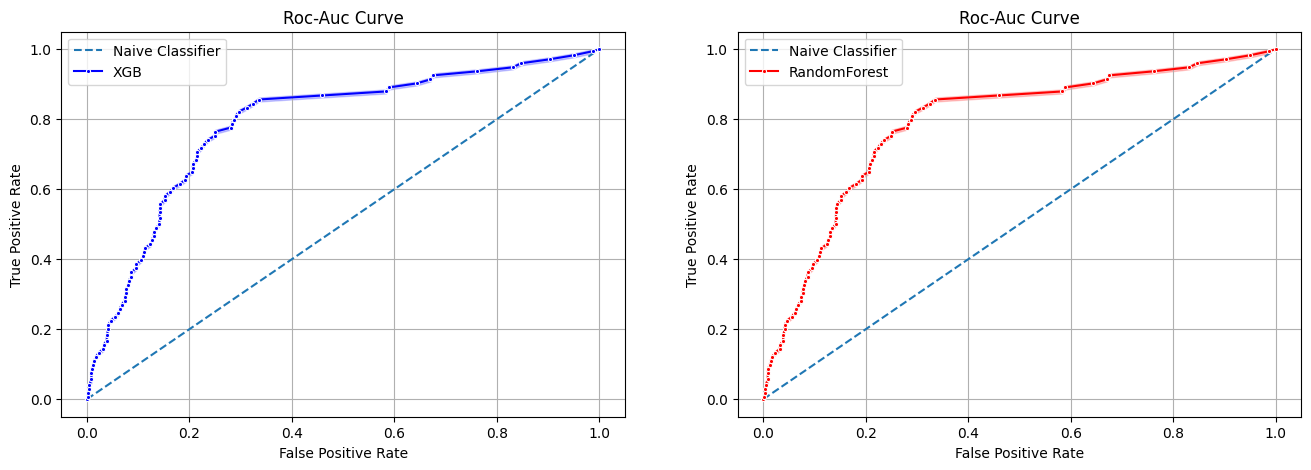

In [213]:
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test_, pos_probs_xgb)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_, pos_probs_xgb)
#---------------
fig, sub = plt.subplots(1, 2, figsize=(16, 5))
subs = sub.flatten()

sns.lineplot(x = np.arange(0, 1.1, 0.1), y = np.arange(0,1.1,0.1), ax = subs[0], ls = "--", label = "Naive Classifier")
sns.lineplot(x = np.arange(0, 1.1, 0.1), y = np.arange(0,1.1,0.1), ax = subs[1], ls = "--", label = "Naive Classifier")

sns.lineplot(x = fpr_xgb, y = tpr_xgb, marker = ".", label = "XGB", ax = subs[0], color = "blue")
sns.lineplot(x = fpr_rf, y = tpr_rf, marker = ".", label = "RandomForest", color = "red", ax = subs[1])

for i, s in enumerate(subs):
    s.set_xlabel("False Positive Rate")
    s.set_ylabel("True Positive Rate")
    s.grid()
    s.set_title("Roc-Auc Curve");

But as already mentioned, the Roc-Auc Curve takes not important metrics such as precision into account.
Precision is a metric which is important when the cost of false positives is high or if the number of incorrect positive predictions should be minimized.
For example in medical diagnosis (side-effects of medication for falsely predicted disease) or Fraud Detection, this metric is quite important.

On the other hand, recall is in focus if the cost of false negatives are high. Hence, it is important to minimize the number of missed positive cases. 
For example, in medical screening for diseases (early detection), Security Systems or search engines recall is important.

Focusing on this discussion, the precision-recall curve witnisses the limitations of the model:
The reached precision through the model is in nearly all thresholds higher than for the Naive guess, but the metric takes on a quite low value.

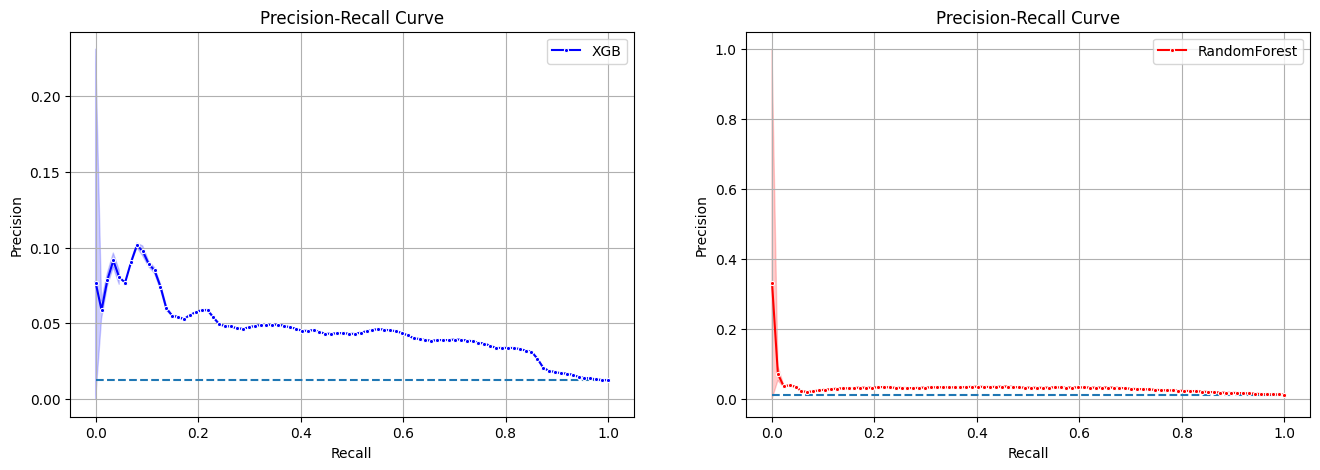

In [218]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test_, pos_probs_xgb)
no_skill = len(y_train_[y_train_==1]) / len(y_train_)
precision_rf, recall_rf, _ = precision_recall_curve(y_test_, pos_probs_rf)

#---------------
fig, sub = plt.subplots(1, 2, figsize=(16, 5))
subs = sub.flatten()

#Naive classifier
sns.lineplot(x = np.arange(0, 1.1, 0.1), y = no_skill, ax = subs[0], ls = "--")
sns.lineplot(x = np.arange(0, 1.1, 0.1), y = no_skill, ax = subs[1], ls = "--")

#xgb and rf
sns.lineplot(x = recall_xgb, y = precision_xgb, marker = ".", ax = subs[0], color = "blue", label = "XGB")
sns.lineplot(x = recall_rf, y = precision_rf, marker = ".", ax = subs[1], color = "red", label = "RandomForest")

for s in subs:
    s.set_xlabel("Recall")
    s.set_ylabel("Precision")
    s.set_title("Precision-Recall Curve")
    s.grid();

Worth to mentioned that the Xgboost model reaches for lower decision thresholds a higher precision at maximum ~ 10 % (at the cost of a lower recall)
On the other side, RandomForest reaches at the cost of minimal recall values, precision values of ~ 38 %. 

**Concerning the performance of the model, the XGBoost model is chosen to be provided to the mail-order company.**

But to close this evaluation part, it has to be stated that the usefulness of a model is dependent on the focus / use of the user for the model. 
* If the mail order company has a very high cost sending out mails and wants to use the model to reduce its cost caused by sending out mails, then the model above is not of great use
* If the mail order company wants to insure with a high probability that all individuals who could potentially be a respondend also get a mail, then the model with a high recall can be of great use

## IV. Conclusion and Outlook

The above analysis aims to develop a supervised learning model for the client, a Mail-Order Company, of Arvato. The client wants to use a model which predicts whether or not an individual will respond to a respective campaign. <br>
In the procedure above a preprocessing pipeline has been developed with several preprocessing steps to prepare the data in a standardized manner for the model training. Four models (Logistic Regression, RandomForest, Adaboost and XGBoost) has been tested for the data at hand and XGBoost as well as RandomForest has been chosen as the best performing models.<br>
These models have been fine-tuned via Grid-Search to find the best Hyperparameter Combination. For the XGBoost algorithm a Roc-Auc-Score of 0.79 could be reached and for the RandomForest a Roc-Auc-Score of 0.75 was measured.<br>

Concerning the results of Roc-Auc Score the models outperformed a Naive Classifier significantly, but it has to be mentioned that the precision score of the both models were quite low. 
There are still many possibilities to improve the model's performance as for example:<br>

* **Handle outliers**: Severely skewed features could be handled via trimming, mean/median imputation or transformation approaches to reduce the influence of these features on the model performance 

* **Take another approach to imputation:** At the moment a simple imputation method is used (most frequent strategy), but it could be possible to use more sophisticated imputation method such as RandomForest Imputation or K-Nearest Neighbor imputation to prevent a possible distortion of a feature and consequently a possible effect on performance 

* **collect more data to make the model's performance more robust**: Provide the models a possibility to learn more about the minority class
* **try out other balancing techniques**: At the moment, an undersampling approach is implemented. But also oversampling could be a possibility to reach better results
* **invest more time in model tuning**: The Hyperparameter tuning phase is time consuming the more features combination are tested. It is possible that a bit more performance can be reached by investing more time.
* **combining distinct models to ensembles**: Implement Meta-classifiers where multiple distinct models (base-level classifiers) are trained and then in e.g. a voting manner a more robust result can be reached. 

<img src = '../data/img/supervised_learning_model.PNG'/>